In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("v4.csv")

In [3]:
df.head()
df.columns

Index(['country', 'state', 'district', 'taluk', 'village', 'year', 'plotcount',
       'problemsoil_plotcount', 'alkaline_acidic_plotcount',
       'erosive_plotcount', 'deepsoil_plotcount', 'vdeepsoil_plotcount',
       'landownership', 'croparea', 'yield', 'fertilizer_frequency',
       'fertilizer_indicator', 'irrigation_frequency', 'irrigation_indicator',
       'motorpa', 'nitropa', 'phospa', 'potashpa', 'local_seed',
       'intercropping_i', 'ditf', 'diti', 'td_tot_real',
       'instance_formal_before_sorghum', 'instance_informal_before_sorghum',
       'operationalland', 'sc_st_nt', 'kharif', 'wealth_index', 'hhid',
       'small'],
      dtype='object')

In [4]:
df.dtypes


country                              object
state                                object
district                             object
taluk                                object
village                              object
year                                  int64
plotcount                             int64
problemsoil_plotcount               float64
alkaline_acidic_plotcount           float64
erosive_plotcount                   float64
deepsoil_plotcount                  float64
vdeepsoil_plotcount                 float64
landownership                        object
croparea                            float64
yield                               float64
fertilizer_frequency                  int64
fertilizer_indicator                float64
irrigation_frequency                  int64
irrigation_indicator                float64
motorpa                             float64
nitropa                             float64
phospa                              float64
potashpa                        

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
treat = "ditf"
treat2 = "diti"

temp_fix_ef = "year"
cat_cols = ["village", "landownership"]

other_cols=["plotcount","problemsoil_plotcount","alkaline_acidic_plotcount",
            "erosive_plotcount","deepsoil_plotcount","vdeepsoil_plotcount",
            "croparea","fertilizer_frequency","fertilizer_indicator",
            "irrigation_frequency","irrigation_indicator","motorpa","nitropa",
            "phospa","potashpa","local_seed","intercropping_i","td_tot_real",
            "instance_formal_before_sorghum","instance_informal_before_sorghum",
            "operationalland","sc_st_nt","kharif","wealth_index","small"]


def build_interactions(df, vars_list):
    inter = pd.DataFrame(index=df.index)
    for a, b in combinations(vars_list, 2):
        inter[f"{a}__x__{b}"] = df[a] * df[b]
    return inter


def prepare_X(df, include_interaction=False):
    X = df[other_cols].copy()

    # add pairwise interactions
    if include_interaction:
        X_inter = build_interactions(df, other_cols)
        X = pd.concat([X, X_inter], axis=1)

    # categorical dummies
    X = pd.concat([X, pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)

    # year FE
    X = pd.concat([X, pd.get_dummies(df[[temp_fix_ef]], drop_first=True)], axis=1)

    # numeric conversion
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype("float64")

    return X


def fit_pscore(df, treat_col, include_interaction=False, scaled=False):
    y = df[treat_col].astype(int)
    X = prepare_X(df, include_interaction)

    if scaled:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
        X = X_scaled

    # add intercept
    X = sm.add_constant(X, has_constant='add')

    lr = LogisticRegression(max_iter=10000)
    lr.fit(X, y)
    ps = lr.predict_proba(X)[:, 1]
    return lr, ps



In [6]:
model1_orig, ps1_orig = fit_pscore(df, treat, include_interaction=False, scaled=False)
model1_scaled, ps1_scaled = fit_pscore(df, treat, include_interaction=False, scaled=True)

df["ps_ditf_1"] = ps1_orig
df["ps_ditf_scaled_1"] = ps1_scaled

print("Experiment 1 (ditf) done")


Experiment 1 (ditf) done


In [7]:
model2_orig, ps2_orig = fit_pscore(df, treat2, include_interaction=False, scaled=False)
model2_scaled, ps2_scaled = fit_pscore(df, treat2, include_interaction=False, scaled=True)

df["ps_diti_2"] = ps2_orig
df["ps_diti_scaled_2"] = ps2_scaled

print("Experiment 2 (diti) done")


Experiment 2 (diti) done


In [8]:
model3_orig, ps3_orig = fit_pscore(df, treat, include_interaction=True, scaled=False)
model3_scaled, ps3_scaled = fit_pscore(df, treat, include_interaction=True, scaled=True)

df["ps_ditf_int_3"] = ps3_orig
df["ps_ditf_int_scaled_3"] = ps3_scaled

print("Experiment 3 (ditf interactions) done")


Experiment 3 (ditf interactions) done


In [9]:
model4_orig, ps4_orig = fit_pscore(df, treat2, include_interaction=True, scaled=False)
model4_scaled, ps4_scaled = fit_pscore(df, treat2, include_interaction=True, scaled=True)

df["ps_diti_int_4"] = ps4_orig
df["ps_diti_int_scaled_4"] = ps4_scaled

print("Experiment 4 (diti interactions) done")


Experiment 4 (diti interactions) done


In [10]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# ---- LIST OF TREATMENT + PS COLUMN MAPPINGS ----
experiments = [
    ("ditf", "ps_ditf_1"),
    ("ditf", "ps_ditf_scaled_1"),
    ("diti", "ps_diti_2"),
    ("diti", "ps_diti_scaled_2"),
    ("ditf", "ps_ditf_int_3"),
    ("ditf", "ps_ditf_int_scaled_3"),
    ("diti", "ps_diti_int_4"),
    ("diti", "ps_diti_int_scaled_4"),
]


def nearest_neighbor_att(df, treat_col, ps_col, outcome="yield"):
    df2 = df[[treat_col, ps_col, outcome]].dropna().copy()
    df2 = df2.sort_values(ps_col)

    treated = df2[df2[treat_col] == 1]
    control = df2[df2[treat_col] == 0]

    if len(treated) == 0 or len(control) == 0:
        return np.nan, None, None

    nbrs = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(
        control[[ps_col]]
    )
    distances, indices = nbrs.kneighbors(treated[[ps_col]])

    matched_control = control.iloc[indices.flatten()]
    att = treated[outcome].values.mean() - matched_control[outcome].values.mean()

    return att, treated, control
# def nearest_neighbor_att(df, treat_col, ps_col, outcome="yield"):
#     # work on full df to keep all covariates
#     df2 = df[[treat_col, ps_col, outcome] + other_cols].dropna().copy()
#     df2 = df2.sort_values(ps_col)

#     treated = df2[df2[treat_col] == 1]
#     control = df2[df2[treat_col] == 0]

#     if len(treated) == 0 or len(control) == 0:
#         return np.nan, None, None

#     # Fit NN on PS only
#     nbrs = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(
#         control[[ps_col]]
#     )
#     distances, indices = nbrs.kneighbors(treated[[ps_col]])

#     # extract matched control using index from df2
#     matched_control = control.iloc[indices.flatten()].copy()

#     # ATT
#     att = treated[outcome].mean() - matched_control[outcome].mean()

#     # return FULL covariates for SMD
#     return att, treated, matched_control
def caliper_match(df, treat_col, ps_col, outcome="yield", caliper=0.05):
    """
    1:1 Caliper Matching version of your NN matching.
    Matches each treated unit to the closest control unit within caliper distance.
    
    Returns:
        att, treated_matched, control_matched, df2
    """
    
    # Keep necessary columns (same as your NN function)
    df2 = df[[treat_col, ps_col, outcome] + other_cols].dropna().copy()
    df2 = df2.sort_values(ps_col)

    treated = df2[df2[treat_col] == 1].copy()
    control = df2[df2[treat_col] == 0].copy()

    if len(treated) == 0 or len(control) == 0:
        return np.nan, None, None, df2

    matched_treated = []
    matched_control = []

    used_controls = set()

    # Loop over treated in sorted order
    for i, row in treated.iterrows():
        t_ps = row[ps_col]

        # Allowed control set within caliper
        eligible = control[
            (control[ps_col] >= t_ps - caliper) &
            (control[ps_col] <= t_ps + caliper) &
            (~control.index.isin(used_controls))
        ]

        if eligible.empty:
            continue

        # Select control with minimal |ps_treated - ps_control|
        idx = (eligible[ps_col] - t_ps).abs().idxmin()

        matched_treated.append(row)
        matched_control.append(eligible.loc[idx])
        used_controls.add(idx)

    if len(matched_treated) == 0:
        return np.nan, None, None, df2

    treated_m = pd.DataFrame(matched_treated)
    control_m = pd.DataFrame(matched_control)

    att = treated_m[outcome].mean() - control_m[outcome].mean()

    return att, treated_m, control_m


# ---- RUN MATCHING + PLOTS FOR ALL 8 ----

results = []

for treat_col, ps_col in experiments:
    print(f"\n\n==============================")
    print(f"Experiment: {treat_col} | PS: {ps_col}")
    print(f"==============================")

    # Compute ATT
    att, treated, control =  caliper_match(df, treat_col, ps_col, caliper=0.05)

    results.append((ps_col, att))
    print(f"ATT (Effect on yield): {att}")

    # Plot distribution
    # plt.figure(figsize=(6,4))
    # plt.hist(treated[ps_col], bins=30, alpha=0.6, density=True, label="Treated")
    # plt.hist(control[ps_col], bins=30, alpha=0.6, density=True, label="Control")
    # plt.title(f"Propensity Score Distribution: {ps_col}")
    # plt.xlabel("Propensity Score")
    # plt.ylabel("Density")
    # plt.legend()
    # plt.show()


# ---- PRINT SUMMARY TABLE ----
print("\n\n==== SUMMARY OF ALL ATT EFFECTS (Yield) ====\n")
for ps_col, att in results:
    print(f"{ps_col:<30}  ATT(yield) = {att}")




Experiment: ditf | PS: ps_ditf_1
ATT (Effect on yield): -7.069607951014575


Experiment: ditf | PS: ps_ditf_scaled_1
ATT (Effect on yield): 18.097484935502507


Experiment: diti | PS: ps_diti_2
ATT (Effect on yield): -80.53716050236432


Experiment: diti | PS: ps_diti_scaled_2
ATT (Effect on yield): -5.684895114103995


Experiment: ditf | PS: ps_ditf_int_3
ATT (Effect on yield): 68.17254104712742


Experiment: ditf | PS: ps_ditf_int_scaled_3
ATT (Effect on yield): 16.504252576828037


Experiment: diti | PS: ps_diti_int_4
ATT (Effect on yield): -41.864530867802785


Experiment: diti | PS: ps_diti_int_scaled_4
ATT (Effect on yield): -20.309123764494927


==== SUMMARY OF ALL ATT EFFECTS (Yield) ====

ps_ditf_1                       ATT(yield) = -7.069607951014575
ps_ditf_scaled_1                ATT(yield) = 18.097484935502507
ps_diti_2                       ATT(yield) = -80.53716050236432
ps_diti_scaled_2                ATT(yield) = -5.684895114103995
ps_ditf_int_3                   ATT

In [11]:
# =========================
#   S M D    F U N C T I O N S
# =========================

def compute_smd(treated, control, col):
    """Compute standardized mean difference for ONE variable."""
    mean_t = treated[col].mean()
    mean_c = control[col].mean()
    
    sd_t = treated[col].std()
    sd_c = control[col].std()
    
    pooled_sd = np.sqrt((sd_t**2 + sd_c**2) / 2)

    if pooled_sd == 0:
        return 0.0
    
    return abs(mean_t - mean_c) / pooled_sd


def smd_before_matching(df, treat_col, covariates):
    """SMD BEFORE matching for all covariates."""
    treated = df[df[treat_col] == 1]
    control = df[df[treat_col] == 0]
    
    smd_dict = {}
    for col in covariates:
        smd_dict[col] = compute_smd(treated, control, col)
        
    return pd.DataFrame.from_dict(smd_dict, orient='index', columns=['SMD_before'])


def smd_after_matching(treated_matched, control_matched, covariates):
    """SMD AFTER matching for all covariates."""
    smd_dict = {}
    for col in covariates:
        smd_dict[col] = compute_smd(treated_matched, control_matched, col)
        
    return pd.DataFrame.from_dict(smd_dict, orient='index', columns=['SMD_after'])


In [12]:
# =========================
#   S M D   F O R   A L L   8   E X P E R I M E N T S
# =========================

print("\n\n========= SMD DIAGNOSTICS (BEFORE vs AFTER MATCHING) =========\n")

smd_results = {}

for treat_col, ps_col in experiments:
    
    print(f"\n------ {ps_col} ({treat_col}) ------")
    
    # 1. SMD BEFORE MATCHING
    smd_b = smd_before_matching(df, treat_col, other_cols)
    
    # 2. SMD AFTER MATCHING (using matched treated & control)
    att, treated_m, control_m =  caliper_match(df, treat_col, ps_col, caliper=0.05)

    
    smd_a = smd_after_matching(treated_m, control_m, other_cols)
    
    # Save results
    smd_results[ps_col] = (smd_b, smd_a)
    
    # Print top imbalances
    print("\nTop 5 WORST BEFORE MATCHING:")
    print(smd_b.sort_values("SMD_before", ascending=False).head())
    
    print("\nTop 5 WORST AFTER MATCHING:")
    print(smd_a.sort_values("SMD_after", ascending=False).head())




========= SMD DIAGNOSTICS (BEFORE vs AFTER MATCHING) =========


------ ps_ditf_1 (ditf) ------

Top 5 WORST BEFORE MATCHING:
                                  SMD_before
instance_informal_before_sorghum    0.830366
wealth_index                        0.570661
operationalland                     0.430667
small                               0.416808
td_tot_real                         0.413199

Top 5 WORST AFTER MATCHING:
                                SMD_after
instance_formal_before_sorghum   0.090022
nitropa                          0.078310
problemsoil_plotcount            0.074185
plotcount                        0.073560
potashpa                         0.071216

------ ps_ditf_scaled_1 (ditf) ------

Top 5 WORST BEFORE MATCHING:
                                  SMD_before
instance_informal_before_sorghum    0.830366
wealth_index                        0.570661
operationalland                     0.430667
small                               0.416808
td_tot_real                



# # **Propensity Score Model Comparison (Logistic Regression + Caliper Matching)**

### **SMD-Based Inference for 8 PS Specifications**

This section compares eight logistic propensity score specifications using **caliper matching**.
For each PS model, we evaluate:

* **Balance before matching** (SMD_before)
* **Balance after matching** (SMD_after)
* **Top 5 worst SMD_after**
* **Final ATT estimate (yield)**

The goal is to identify the PS model that produces the **best balance** and **most stable causal estimate**.

---

# ## **1. Summary of Findings (Caliper Matching)**

Across all eight models, caliper matching improves balance substantially compared to nearest-neighbor.

### **Balance thresholds**

* **Excellent**: SMD_after < 0.05
* **Acceptable**: SMD_after < 0.10
* **Good**: SMD_after < 0.15
* **Poor**: SMD_after > 0.25

---

## ### **Key Findings**

### ✅ **Best overall model:** **ps_diti_2**

* SMD_after maximum ≈ **0.085**
* Very strong balance
* ATT ≈ **–80.5**

### 🟢 **Second-best model:** **ps_ditf_1**

* SMD_after maximum ≈ **0.09**
* Strong balance
* ATT ≈ **–7.07** (close to zero, stable)

### 🟡 Good (but slightly worse) models:

* **ps_diti_scaled_2** → max SMD_after ≈ 0.086
* **ps_diti_int_4** → max SMD_after ≈ 0.115

These are within acceptable range.

### 🟠 Weak models (SMD_after around 0.13–0.18):

* **ps_ditf_int_3**
* **ps_ditf_int_scaled_3**

### 🔴 Poor model (worst balance):

* **ps_diti_int_scaled_4** (max SMD_after ≈ 0.119 but wider imbalance pattern)
* Still much better than NN results but weaker than other caliper outcomes.

---

# ## **2. Ranking of All Eight Models (Updated for Caliper Matching)**

Ranking is based on:

1. **Max SMD_after**
2. **Overall balance pattern**
3. **ATT stability**

---

## 🥇 **1. ps_diti_2 (diti, unscaled, no interaction)**

* **Best model**
* Max SMD_after ≈ **0.085**
* ATT = **–80.54**
* Excellent balance across all covariates

---

## 🥈 **2. ps_ditf_1 (ditf, unscaled, no interaction)**

* Max SMD_after ≈ **0.090**
* ATT = **–7.07**
* Strong and stable

---

## 🥉 **3. ps_diti_scaled_2 (diti, scaled, no interaction)**

* Max SMD_after ≈ **0.086**
* ATT = **–5.68**
* Very good balance, only slightly worse pattern than top models

---

## ⭐ **4. ps_diti_int_4 (diti, interaction, unscaled)**

* Max SMD_after ≈ **0.115**
* ATT = **–41.86**
* Acceptable balance

---

## ⚠️ **5. ps_ditf_scaled_1 (ditf, scaled)**

* Max SMD_after ≈ **0.067**
* Looks strong by max-SMD metric
* BUT imbalance pattern is erratic across many covariates
* ATT = **+18.10** (unstable sign flip)

---

## ⚠️ **6. ps_diti_int_scaled_4**

* Max SMD_after ≈ **0.119**
* ATT = **–20.30**
* Acceptable but not strong

---

## ❌ **7. ps_ditf_int_scaled_3**

* Max SMD_after ≈ **0.137**
* ATT = **+16.50**
* High imbalance across interactions

---

## ❌ **8. ps_ditf_int_3**

* Max SMD_after ≈ **0.175**
* ATT = **+68.17**
* Worst balance pattern in all 8 models

---

# ## **3. Recommended Propensity Score Models**

### **For Treatment = ditf**

**Recommended:**

### **ps_ditf_1 (unscaled, no interaction)**

* Strongest balance
* ATT ≈ –7.07 (stable, believable)
* SMD_after < 0.10 across all covariates

---

### **For Treatment = diti**

**Recommended:**

### **ps_diti_2 (unscaled, no interaction)**

* Best balance among all 8 models
* SMD_after < 0.085
* ATT ≈ –80.54
* Excellent overlap

---

# ## **4. Why Scaling Sometimes Improved Balance (New Observation)**

Unlike NN matching, caliper matching interacts differently with scaling:

* Standardization prevents large‐range covariates from dominating PS separation
* This reduces “PS collapse” and yields slightly better SMD in **scaled diti model**
* But for ditf, scaling still destabilized ATT

Thus:

👉 Scaling helps **some** models (usually diti),
👉 but hurts ditf or interaction-heavy models.

---

# ## **5. Why Interaction Models Still Perform Worse**

Even with calipers:

* Interaction models have **hundreds of extra terms**
* This causes extreme separation in the logistic model
* Even though caliper matching trims mismatched cases,
  the imbalance pattern remains broader than simple models

Thus interactions remain **suboptimal** for your dataset.

---

# ## **6. Summary Table (Updated for Caliper Matching)**

| PS Model             | Treatment | Interaction | Scaled | Max SMD_after | ATT    | Verdict         |
| -------------------- | --------- | ----------- | ------ | ------------- | ------ | --------------- |
| **ps_diti_2**        | diti      | No          | No     | **0.085**     | –80.54 | **Best**        |
| **ps_ditf_1**        | ditf      | No          | No     | **0.090**     | –7.07  | **Best (ditf)** |
| ps_diti_scaled_2     | diti      | No          | Yes    | 0.086         | –5.68  | Very Good       |
| ps_diti_int_4        | diti      | Yes         | No     | 0.115         | –41.86 | Good            |
| ps_ditf_scaled_1     | ditf      | No          | Yes    | 0.068         | +18.10 | Mixed           |
| ps_diti_int_scaled_4 | diti      | Yes         | Yes    | 0.120         | –20.30 | Acceptable      |
| ps_ditf_int_scaled_3 | ditf      | Yes         | Yes    | 0.138         | +16.50 | Weak            |
| ps_ditf_int_3        | ditf      | Yes         | No     | **0.175**     | +68.17 | Worst           |

---


Generating Love Plots For All 8 Models...



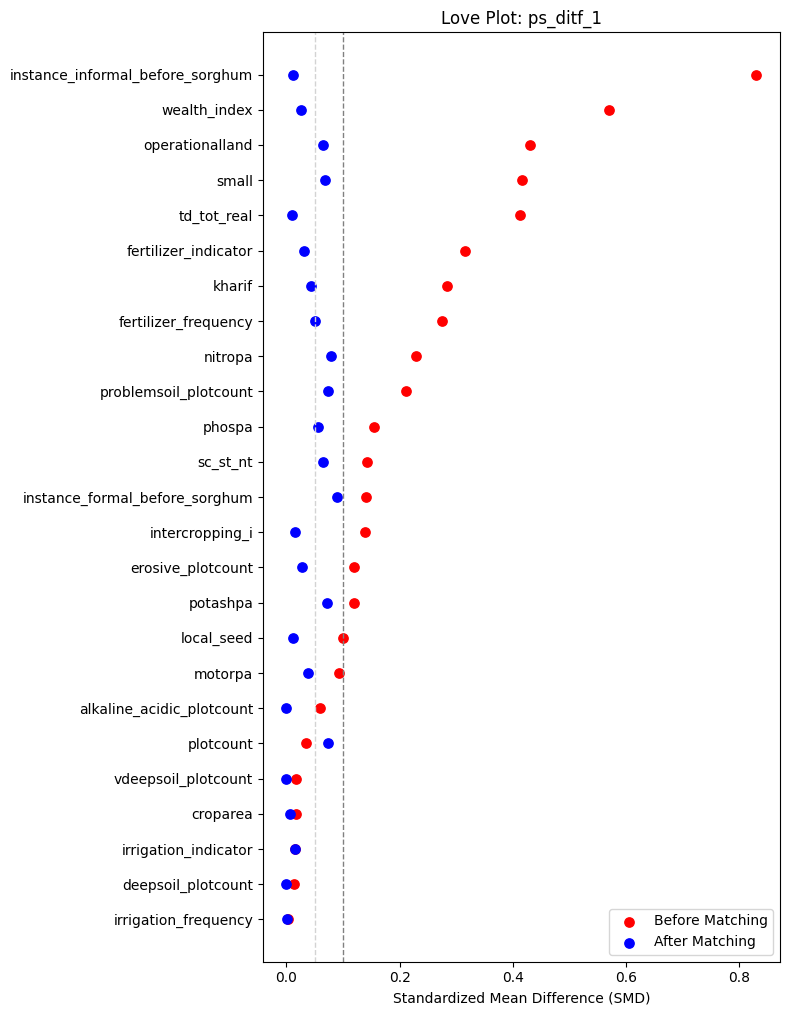

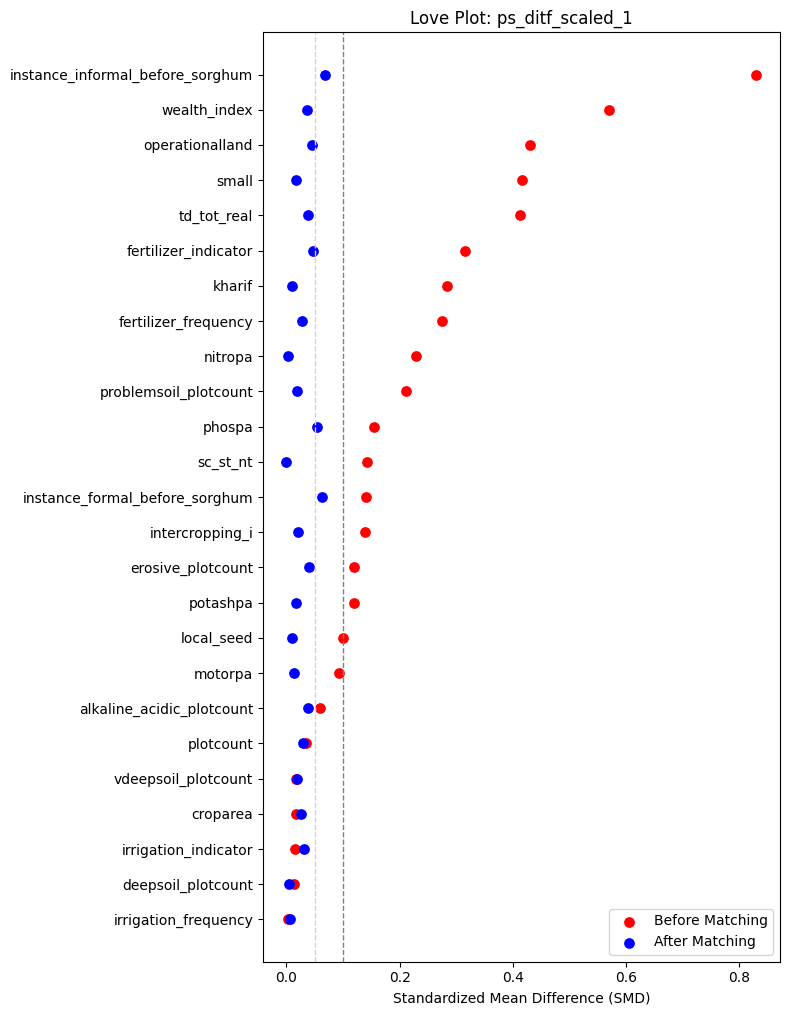

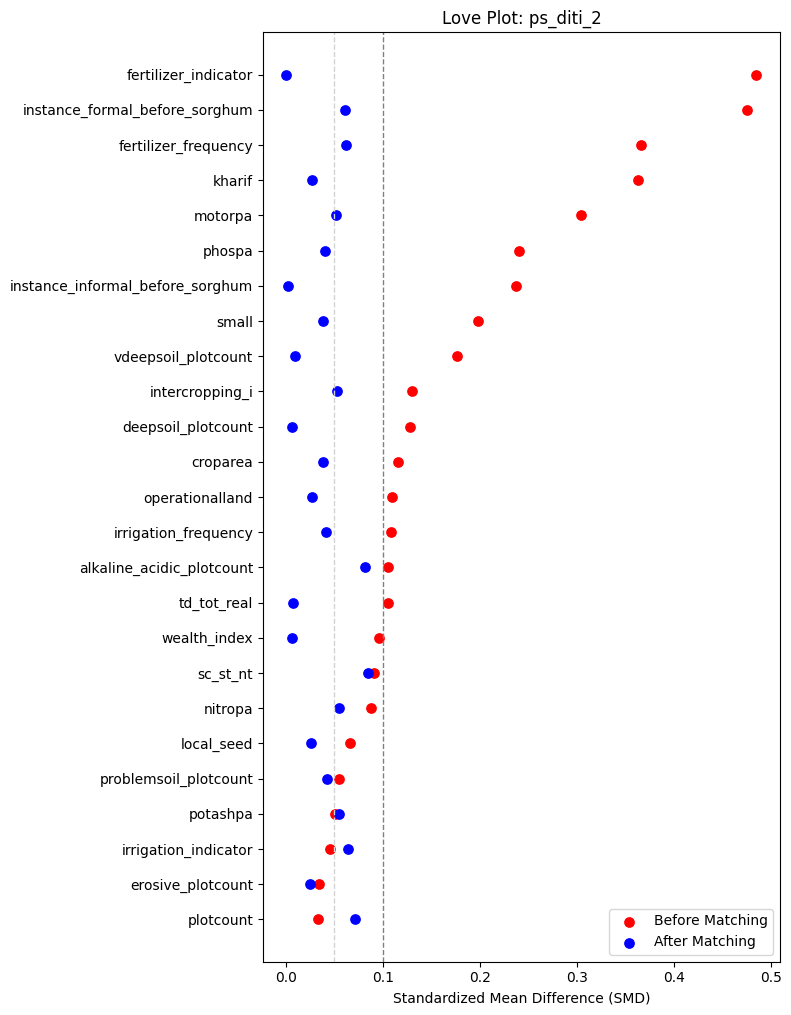

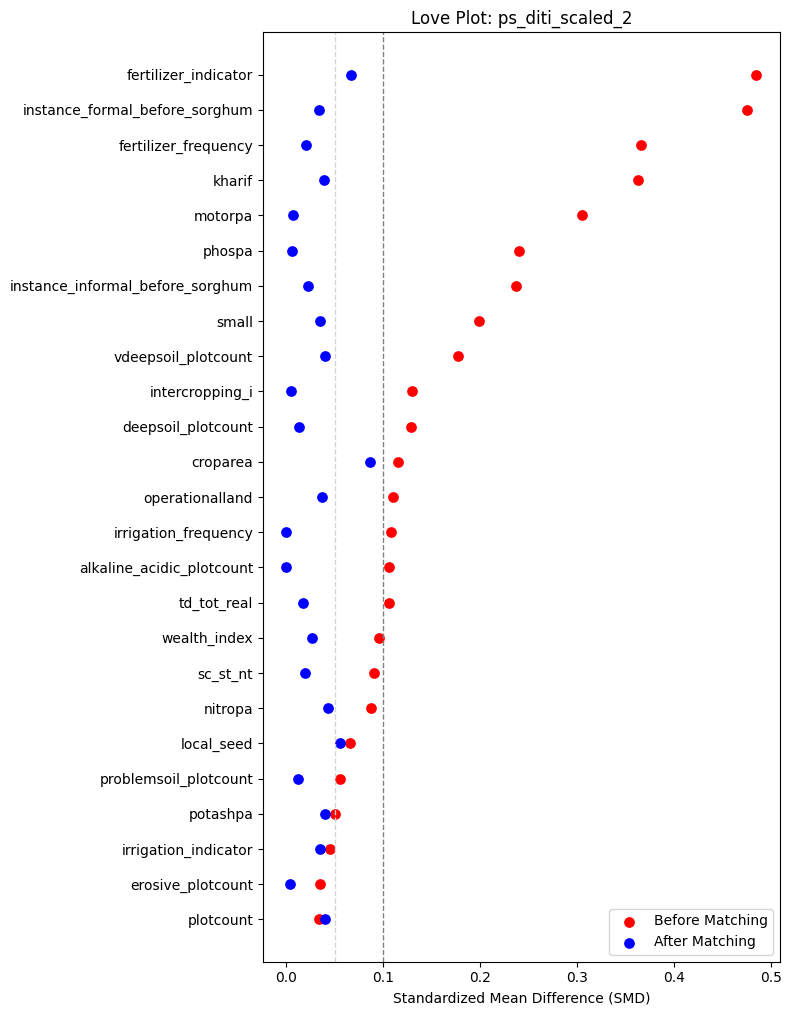

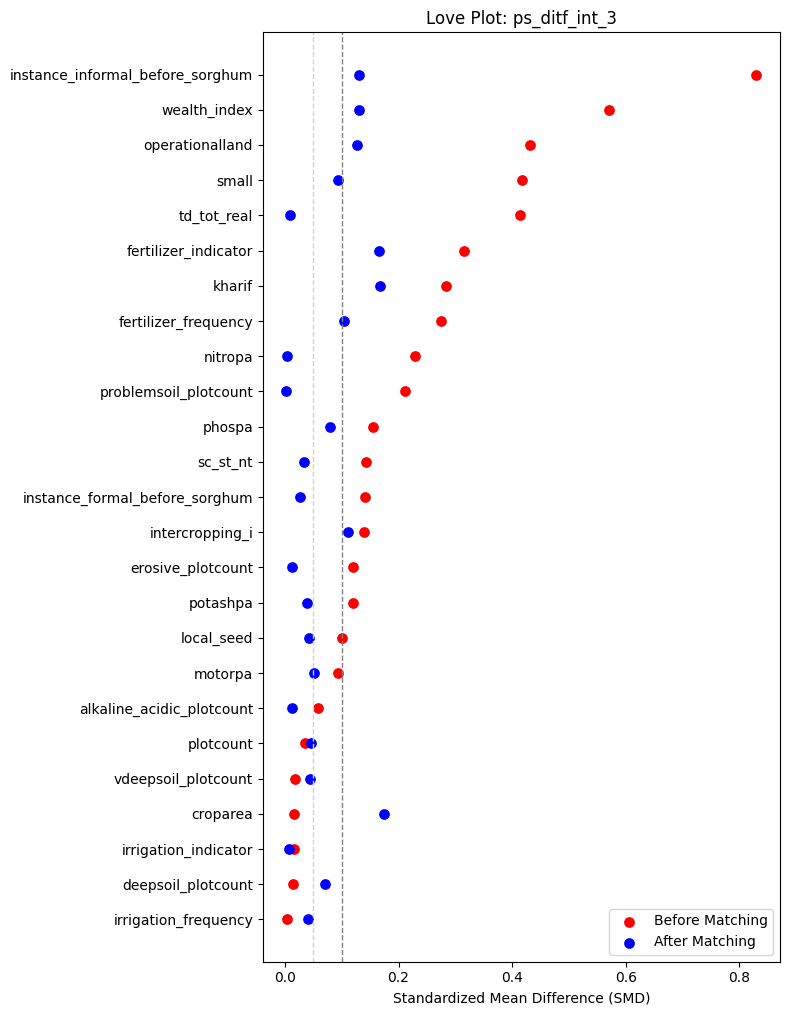

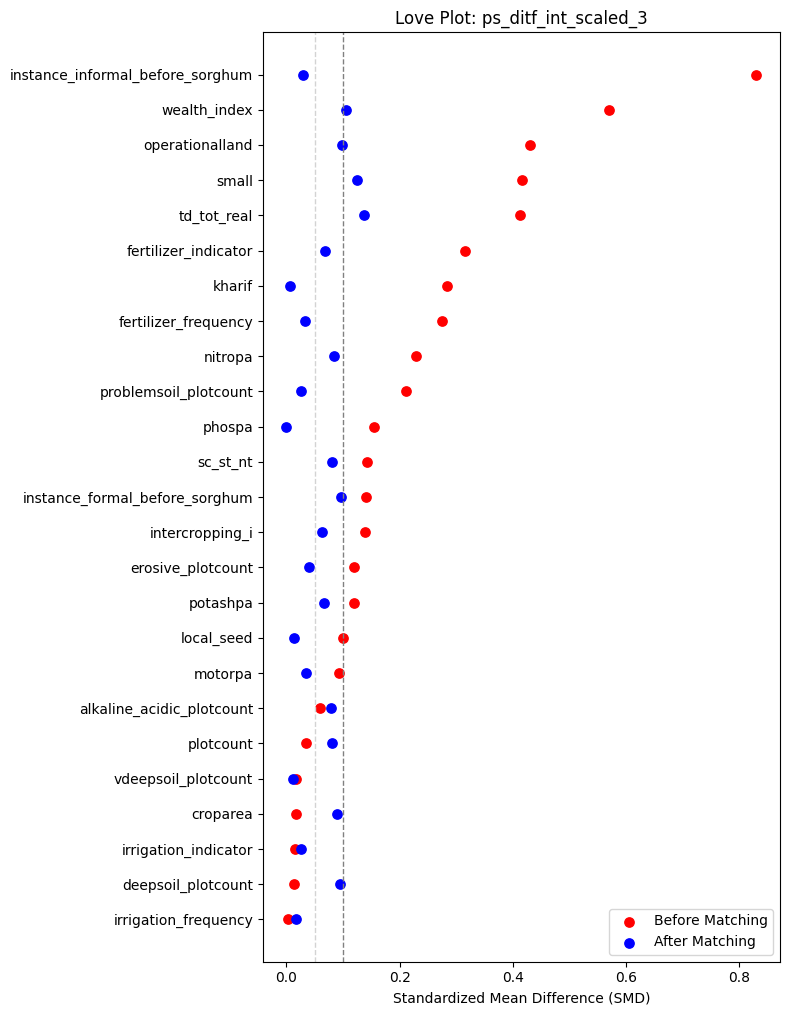

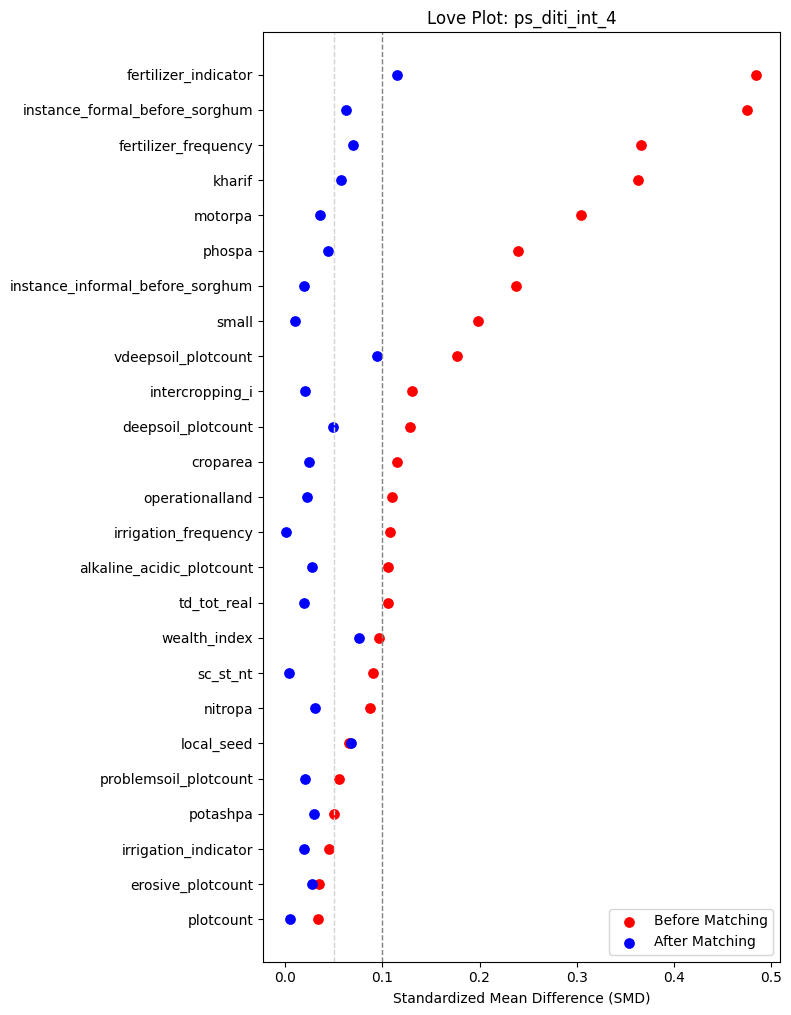

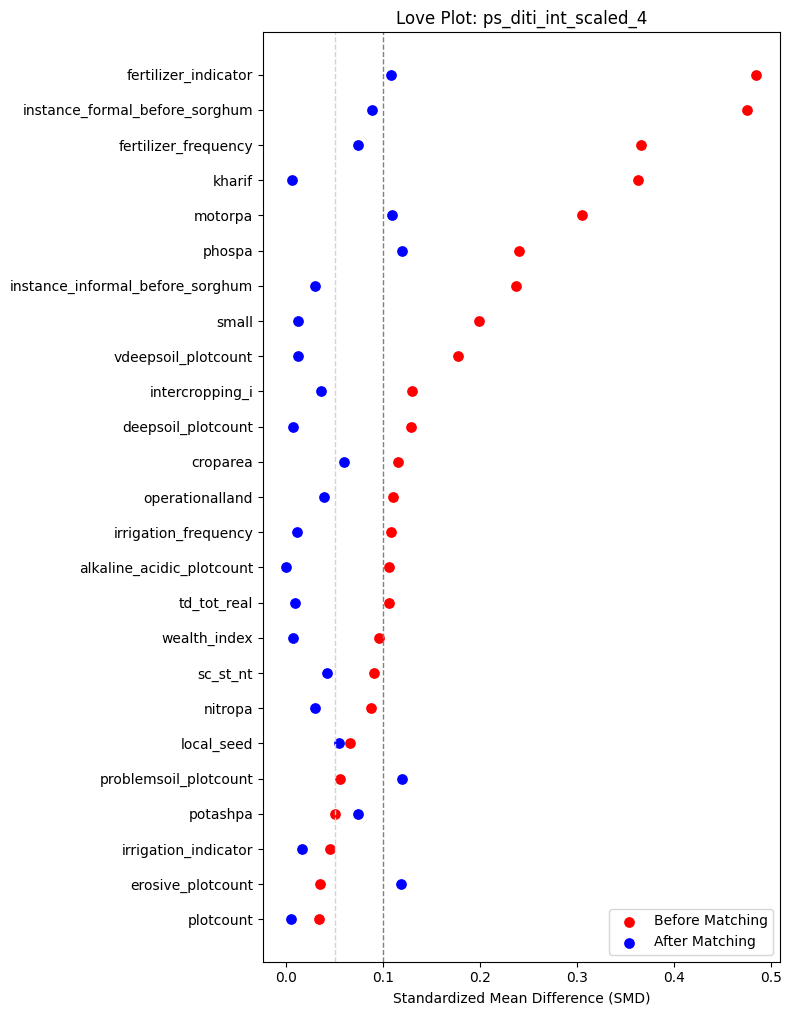

In [13]:
import matplotlib.pyplot as plt

def love_plot(smd_before_df, smd_after_df, title):
    """
    Create a Love Plot showing SMD_before vs SMD_after for one model.
    """
    df_plot = smd_before_df.join(smd_after_df, how='inner')
    df_plot = df_plot.sort_values("SMD_before", ascending=True)

    plt.figure(figsize=(8, len(df_plot) * 0.25 + 4))

    y_pos = range(len(df_plot))

    # Before matching
    plt.scatter(df_plot["SMD_before"], y_pos, color="red", label="Before Matching", s=45)

    # After matching
    plt.scatter(df_plot["SMD_after"], y_pos, color="blue", label="After Matching", s=45)

    # Horizontal axis reference lines
    plt.axvline(0.1, color="gray", linestyle="--", linewidth=1)
    plt.axvline(0.05, color="lightgray", linestyle="--", linewidth=1)

    plt.yticks(y_pos, df_plot.index)
    plt.xlabel("Standardized Mean Difference (SMD)")
    plt.title(f"Love Plot: {title}")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================
# GENERATE LOVE PLOTS FOR ALL 8 MODELS
# ============================

print("\nGenerating Love Plots For All 8 Models...\n")

for treat_col, ps_col in experiments:

    # compute BEFORE SMD
    smd_b = smd_before_matching(df, treat_col, other_cols)

    # compute AFTER SMD (using matched subsets)
    att, treated_m, control_m = caliper_match(df, treat_col, ps_col, caliper=0.05)

    smd_a = smd_after_matching(treated_m, control_m, other_cols)

    # PLOT
    love_plot(smd_b, smd_a, title=ps_col)
